# CS470 - Introduction to Artificial Intelligence

#### Prof. Ho-Jin Choi
#### School of Computing, KAIST
---

## Information
**Please write your student ID and name here!**
- Student ID: 20190417
- Name: Hyunwoo You

---

## Homework #1: Dog and Cat Breed Identification

In this assignment, you are going to train a convolutional neural network to classify images of dog and cats as their breeds. Please follow the steps below to continue this assignment.

### Guidelines
Copy this example to your Google Colab and edit it to complete your assignment. We should be able to reproduce your results using your code and pre-trained model. Please double-check if your code runs without error properly. Submissions failed to run or reproduce the results will get a substantial penalty.

### Extra points
TAs will rank the submissions based on the test accuracy and assign extra points according to the rank. (The baseline accuracy is roughly 85%.)
 
If you improve your model's accuracy using various techniques (e.g., more stacking layer, early stopping, etc.), then please write how to improve into the block at the bottom. 

### Deliverables

- Download your Colab notebook, and your pre-trained model (i.e., checkpoint), and submit a zip file in a format: [StudentID].zip. Please double-check that you load your pre-trained model properly.
- Your assignment should be submitted through KLMS. All other submissions (e.g., via email) will not be considered as valid submissions.

### Due date

- **23:59:59 Sep 21th (Tue).**
- Late submission is allowed until 23:59:59 Sep 23th (Thu).
- Late submission will be applied 20% penalty.

In [1]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

# DO NOT EDIT THE FOLLOWING LINES
# THESE LINES ARE FOR REPRODUCIBILITY
np.random.seed(1)
tf.random.set_seed(1)

### 1. Load the Oxford-IIIT Pet dataset
In this assignment, you will use the Oxford-IIIT pet dataset which contains 37 category pet images with roughly 200 images for each class. 

![Oxford-IIIT Pet Dataset](https://github.com/keai-kaist/CS492F-Spring/blob/master/Assignments/Homework%201/images/oxford-iiit-pet.png?raw=true)

Please note that the images have large variations in scale, pose and lighting. Let's import and load the Oxford-IIIT pet dataset using TensorFlow Datasets:

In [2]:
import tensorflow_datasets as tfds

labels = [
    'abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound',
    'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua',
    'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired',
    'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon',
    'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll',
    'russian_blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese',
    'sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier',
]

dataset, metadata = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=True)
raw_train, raw_test = dataset['train'], dataset['test']

Let's visualize what some of these images and their corresponding training labels look like.

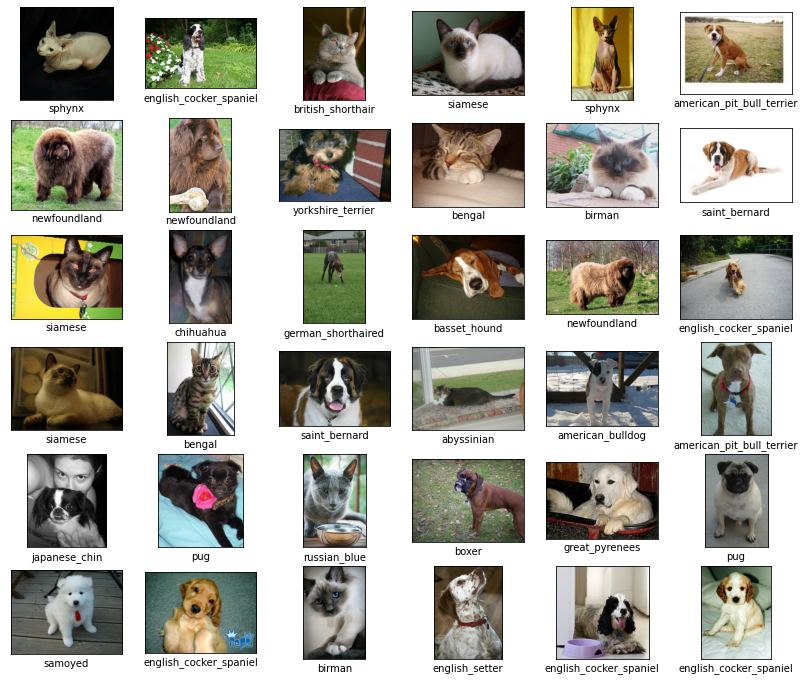

In [3]:
plt.figure(figsize=(14, 12))

for index, (image, label) in enumerate(dataset['train'].take(36)):
    plt.subplot(6, 6, index + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    plt.xlabel(labels[label.numpy()])

### 2. Preprocess the dataset

#### Problem 1
Define a function to preprocess the dataset. The function should **scale the input channels** to a range of [-1, 1] and **resize the images** to a fixed size, `IMAGE_SIZE`.

In [4]:
IMAGE_SIZE = (224, 224)

# TODO: Define a function to preprocess the dataset. 
#       The function should scale the input channels to a range of [-1, 1] and 
#                           resize the images to a fixed size, IMAGE_SIZE
### START CODE HERE ###

def hw1_preprocess(image, label):
    image = tf.cast(image, tf.float32)

    image = (image / 127.5) - 1

    image = tf.image.resize(image, IMAGE_SIZE)

    return image, label
### END CODE HERE ###

#### Problem 2
Apply the defined preprocessing function to `raw_train` and `raw_test`. Then, shuffle the dataset and combine them into batches.

In [5]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1024

# TODO: Apply the defined preprocessing function to `raw_train` and `raw_test`
#       Then, shuffle the dataset and combine them into batches
### START CODE HERE ###

train = raw_train.map(hw1_preprocess)
test = raw_test.map(hw1_preprocess)

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

image_batch, label_batch =  next(iter(train_batches.take(1)))

print(image_batch.shape)
print(label_batch.shape)
### END CODE HERE ###

(32, 224, 224, 3)
(32,)


### 3. Build the model
In this assignment, we are going to train the convolutional neural network using transfer learning.

#### Problem 3
Load `InceptionV3` model without the final classification layer using `tf.keras.applications.InceptionV3`. Then, freeze the model to prevent it from being trained.

In [6]:
# TODO: Load InceptionV3 model without the final classification layer
#       Then, freeze the model to prevent it from being trained
### START CODE HERE ###
IMAGE_SHAPE = (224, 224, 3)

hw1_model = tf.keras.applications.InceptionV3(input_shape = IMAGE_SHAPE, include_top = False, weights = 'imagenet')
feature_batch = hw1_model(image_batch)

print(image_batch.shape, '->', feature_batch.shape)

hw1_model.trainable = False

### END CODE HERE ###

(32, 224, 224, 3) -> (32, 5, 5, 2048)


#### Problem 4
Define a convolutional neural network using the loaded `InceptionV3` to classify images of dogs and cats as their breeds. Then, compile your model with appropriate parameters.

In [7]:
# TODO: Define a convolutional neural network using the loaded InceptionV3
#       Then, compile your model with appropriate parameters
### START CODE HERE ###
lr = 0.0001

hw1_cnn = tf.keras.Sequential([
    hw1_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2048, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(37, activation = 'softmax')
])

hw1_cnn.compile(
    optimizer = tf.keras.optimizers.Adam(lr),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['sparse_categorical_accuracy'],
)

hw1_cnn.summary()
### END CODE HERE ###

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dense_1 (Dense)              (None, 37)                75813     
Total params: 26,074,949
Trainable params: 4,272,165
Non-trainable params: 21,802,784
_________________________________________________________________


### 4. Train the model

#### Problem 5
Now, train the model at least 10 epochs.

In [8]:
# TODO: Train the model at leat 10 epochs
### START CODE HERE ###

initial_epochs = 10

history = hw1_cnn.fit(
    train_batches,
    validation_data=test_batches,
    epochs  = initial_epochs,
)
### END CODE HERE ###

Epoch 1/10
115/115 [==============================] - 15s 105ms/step - loss: 3.0462 - sparse_categorical_accuracy: 0.7416 - val_loss: 2.3836 - val_sparse_categorical_accuracy: 0.8814
Epoch 2/10
115/115 [==============================] - 11s 93ms/step - loss: 2.2950 - sparse_categorical_accuracy: 0.9011 - val_loss: 2.3003 - val_sparse_categorical_accuracy: 0.8855
Epoch 3/10
115/115 [==============================] - 11s 93ms/step - loss: 2.1422 - sparse_categorical_accuracy: 0.9231 - val_loss: 2.2347 - val_sparse_categorical_accuracy: 0.8828
Epoch 4/10
115/115 [==============================] - 11s 94ms/step - loss: 2.0155 - sparse_categorical_accuracy: 0.9459 - val_loss: 2.1408 - val_sparse_categorical_accuracy: 0.8893
Epoch 5/10
115/115 [==============================] - 11s 94ms/step - loss: 1.8992 - sparse_categorical_accuracy: 0.9587 - val_loss: 2.0998 - val_sparse_categorical_accuracy: 0.8858
Epoch 6/10
115/115 [==============================] - 11s 94ms/step - loss: 1.8192 - spar

#### Problem 6
To fine-tune the model, unfreeze the top layers of the model. Please note that you should carefully choose layers to be frozen. Then, compile the model again with appropriate parameters.

In [9]:
# TODO: Unfreeze the top layers of the model
#       Compile the model with appropriate parameters
### START CODE HERE ###

save_dir = 'models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
hw1_cnn.save(os.path.join(save_dir, 'hw1_model.h5'))

hw1_model.trainable = True
fine_tune = 300

for layer in hw1_model.layers[:fine_tune]:
  layer.trainable = False

hw1_cnn.compile(
  optimizer = tf.keras.optimizers.Adam(lr),
  loss = 'sparse_categorical_crossentropy',
  metrics = ['sparse_categorical_accuracy'],
)
### END CODE HERE ###

#### Problem 7
Fine-tune the model at least 10 epochs.

In [10]:
# TODO: Fine-tune the model at least 10 epochs
### START CODE HERE ###
initial_epochs = 10

history = hw1_cnn.fit(
    train_batches,
    epochs  = initial_epochs,
    validation_data=test_batches,
)

### END CODE HERE ###

Epoch 1/10
115/115 [==============================] - 14s 102ms/step - loss: 1.4165 - sparse_categorical_accuracy: 0.9739 - val_loss: 1.6554 - val_sparse_categorical_accuracy: 0.8847
Epoch 2/10
115/115 [==============================] - 11s 96ms/step - loss: 1.3051 - sparse_categorical_accuracy: 0.9823 - val_loss: 1.6033 - val_sparse_categorical_accuracy: 0.8790
Epoch 3/10
115/115 [==============================] - 11s 96ms/step - loss: 1.2136 - sparse_categorical_accuracy: 0.9853 - val_loss: 1.5258 - val_sparse_categorical_accuracy: 0.8850
Epoch 4/10
115/115 [==============================] - 11s 96ms/step - loss: 1.1367 - sparse_categorical_accuracy: 0.9823 - val_loss: 1.4328 - val_sparse_categorical_accuracy: 0.8828
Epoch 5/10
115/115 [==============================] - 12s 97ms/step - loss: 1.0625 - sparse_categorical_accuracy: 0.9829 - val_loss: 1.3628 - val_sparse_categorical_accuracy: 0.8891
Epoch 6/10
115/115 [==============================] - 11s 96ms/step - loss: 0.9899 - spar

### 4. Evaluate accuracy

#### Problem 8
Evaluate the trained model using test dataset and print the test accuracy of the model.

In [11]:
# TODO: Evaluate the model using test dataset
### START CODE HERE ###
history = hw1_cnn.evaluate(
    test_batches,
)
### END CODE HERE ###

115/115 [==============================] - 5s 45ms/step - loss: 1.0839 - sparse_categorical_accuracy: 0.8839


### 5. How to improve

If you have improved the performance of your model, please fill in this block.

1. I added some Dense layer with relu activation, input shaped 2048.
2. For preventing the overfit problem, I added an dropout layer 0.2. Checked that it was general to add with parameter 0.2 in the Internet.
3. Also for the overfit, I used L2 kernel regurlarizer. The final output was as 0.89 for not fine tuned model.